# MEng Computer Science Thesis Implementation

**Title:** Benchmarking Persian LLMs Versus State-of-the-Art NLP Models for Sentiment Analysis <br/>
**Student Name:** Seyyed Jalal Tabatabaee <br/>
**Student ID:** GH1033801 <br/>
**Supervisor:** Prof. Dr. Reza Babaei <br/>
**Semester:** Summer 2025 <br/>
**University:** Gisma University of Applied Sciences <br/>
**Github Link:** https://github.com/shayantabatabaee/llm-sentiment-analysis <br/>
**Dataset Link:** https://github.com/persiannlp/parsinlu



### Introduction

This project focuses on sentiment analysis for the Persian language, a low-resource language that has been underexplored in modern NLP research. While most sentiment analysis studies have been conducted in English, Persian poses unique challenges due to its complex grammar, diverse vocabulary, and the absence of diacritics.

Traditional approaches to sentiment analysis involve steps like text preprocessing, embedding generation, and classification using machine learning (ML) or deep learning (DL) models. However, with the emergence of large language models (LLMs) such as ChatGPT, new techniques like zero-shot and few-shot prompting have shown promising results — even without fine-tuning.

This research benchmarks Persian LLMs (with fewer parameters) on the ParsiNLU sentiment dataset and compares their performance against state-of-the-art traditional models like BERT. The goal is to investigate whether smaller, Persian-specific LLMs can offer performance comparable to larger multilingual models while being more cost-efficient and practical for real-world applications.



### Install Libraries

In [1]:
# !pip install -q datasets
# !pip install -q pandas
# !pip install -q torch
# !pip install -q transformers
# !pip install -U -q accelerate
# !pip install -q tqdm
# !pip install -q scikit-learn
# !pip install -q seaborn
# !pip install -q numpy

### Import Libraries

In [2]:
import os

os.environ["FORCE_TF_AVAILABLE"] = "0"
os.environ["USE_TF"]="0"

In [3]:
import re
import copy
import math
import torch
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset
from kaggle_secrets import UserSecretsClient
from IPython.display import display, display_html
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig, LlamaTokenizer, LlamaForCausalLM
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

### Initialize Variables

In [4]:
DATASET_URL = "https://raw.githubusercontent.com/persiannlp/parsinlu/master/data/sentiment-analysis/food.jsonl"
LABEL_MAP = {
    "3": "OTHER",
    "2": "POSITIVE",
    "1": "POSITIVE",
    "0": "NEUTRAL",
    "-1": "NEGATIVE",
    "-2": "NEGATIVE"
}
TEST_COUNT = 190
RANDOM_STATE = 18
os.environ['HF_TOKEN'] = UserSecretsClient().get_secret("HF_TOKEN")
HUGGING_FACE_CACHE_DIR = "/kaggle/working/hcache"

In [5]:
label_en_fa = {
    "OTHER": "سایر",
    "POSITIVE": "مثبت",
    "NEUTRAL": "خنثی",
    "NEGATIVE": "منفی"
}
label_fa_en = {v:k for k,v in label_en_fa.items()}

## Dataset Preprocessing

To ensure a direct comparison with the baseline study [(Abaskohi et al., 2024)](https://arxiv.org/pdf/2404.02403), we used the same dataset and fixed the random seed. Additionally, we merged the original six sentiment categories into four, matching the label structure used in the baseline. The original dataset contains six labels: *VERY_POSITIVE, POSITIVE, NEUTRAL, NEGATIVE, VERY_NEGATIVE,* and *OTHER*. For our analysis, we merged *VERY_POSITIVE* with *POSITIVE* and *VERY_NEGATIVE* with *NEGATIVE*.

### Load Dataset

In [6]:
dataset = load_dataset("json", data_files=DATASET_URL)
df = dataset['train'].to_pandas()
df = df[['review', 'sentiment']]
df['sentiment'] = df['sentiment'].map(LABEL_MAP)

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
sub_df = df.sample(n=TEST_COUNT, random_state=RANDOM_STATE)

### Visualize Dataset

In [8]:
def insight(data):
  print(f"Dataset shape: {data.shape}", end="\n\n")
  print("Five sample of data")
  display(data.head(5))
  print("\n\nDataset info", end="\n\n")
  display(data['sentiment'].value_counts())
  data['sentiment'].value_counts().plot.bar(x="Sentiment", y="Count", rot=45)

Dataset shape: (1917, 2)

Five sample of data


,review,sentiment
0,من یه مدته فقط از این محصول استفاده میکنم اما ...,OTHER
1,اگه بخوای به صورت مکمل استفاده اش کنی خوبه وار...,POSITIVE
2,طعم خیلی خوبی داره و توضیحات کالا کاملا با خود...,POSITIVE
3,من این رو که گرفتم خیلی به نظر مونده بود و بشد...,NEGATIVE
4,کلا که نوشابه محصول مفیدی نیست. اما اونایی که ...,POSITIVE




Dataset info



sentiment
POSITIVE    860
NEGATIVE    843
OTHER       184
NEUTRAL      30
Name: count, dtype: int64

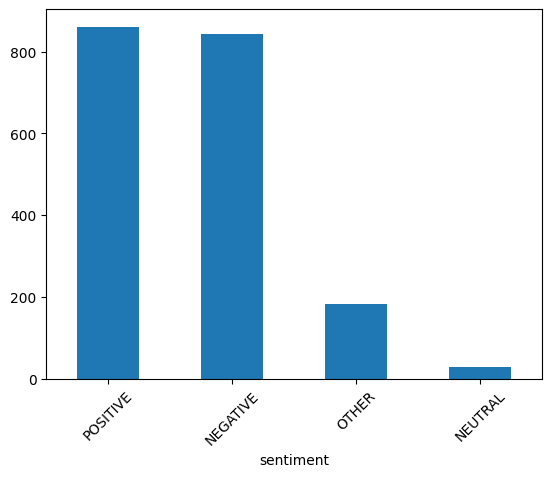

In [9]:
insight(df)

Dataset shape: (190, 2)

Five sample of data


,review,sentiment
1634,فقط بدیه این محصول اینه که حد اکثر ۱۰ عدد میشه...,OTHER
1891,نسبت به قیمت جدیدش قهوه های بهتری رو توی این ر...,NEGATIVE
858,قطر 1 این برندو جایی ندیدم.اتفاقا دنبالش بودم ...,POSITIVE
684,رگ گیری که اصلا نشده بود و کار خیلی سختی بود ر...,NEGATIVE
446,طعم خیلی خوب بود و قیمتش درشگفت انگیز عالی بود,POSITIVE




Dataset info



sentiment
POSITIVE    97
NEGATIVE    66
OTHER       26
NEUTRAL      1
Name: count, dtype: int64

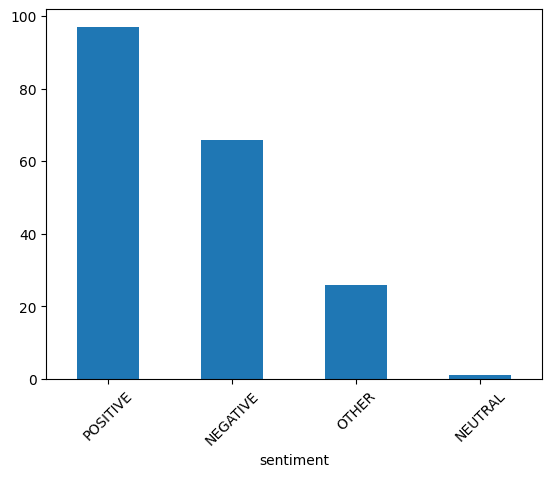

In [10]:
insight(sub_df)

## Prompts

In [11]:
def get_message(prompt):
  return [{"role": "system", "content": prompt[0]},{"role": "user", "content": prompt[1]}]

### System Prompts

In [12]:
system_prompt_01 = """
تو یک دستیار هوشمند برای تحلیل احساسات هستی.
یک نظر کوتاه درباره ی غذا به زبان فارسی دریافت میکنی.
وظیفه‌ی تو این است که احساس کلی نظر را در یکی از چهار دسته‌ی زیر طبقه‌بندی کنی:

- مثبت
- منفی
- خنثی
- سایر

فقط یکی از این چهار برچسب را برگردان. هیچ متن اضافی، توضیح، یا عبارتی مانند «احساس:» در پاسخ ننویس.
اگر احساس نظر نامشخص، متناقض یا ترکیبی بود، فقط برچسب «سایر» را برگردان
"""

In [13]:
system_prompt_02 = """
You are an AI assistant for sentiment analysis.
You will receive a short user opinion about food, written in Persian.
Your task is to classify the overall sentiment of the opinion as one of the following four categories:

- POSITIVE
- NEGATIVE
- NEUTRAL
- OTHER

Return ONLY one of the four labels listed above. Do not include any additional text, explanations, or prefixes such as 'Sentiment:'.
If the sentiment is unclear, contradictory, or mixed, return OTHER.
"""

### Zero-Shot User Prompts

In [14]:
zs_user_prompt_01= """
نظر: REVIEW
احساس:
"""

In [15]:
zs_user_prompt_02="""
Review: REVIEW
Sentiment:
"""

### Few-Shot User Prompts

In [16]:
diff_df = df.loc[~df.index.isin(sub_df.index)]
def create_examples_df(df, n_samples):
    groups = df['sentiment'].unique()
    sampled = []

    for sentiment in groups:
        group_df = df[df['sentiment'] == sentiment]
        sampled_df = group_df.sample(n=n_samples, random_state=RANDOM_STATE)
        sampled.append(sampled_df)

    return pd.concat(sampled).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [17]:
def create_example_prompts(n_samples):
  examples_df = create_examples_df(diff_df, n_samples)
  en_examples = ""
  fa_examples = ""
  for i, row in examples_df.iterrows():
    en_examples += f"Example {i+1}:\n"
    en_examples += f"Review: {row['review']}\n"
    en_examples += f"Sentiment: {row['sentiment']}\n"

    fa_examples += f"مثال {i+1}:\n"
    fa_examples += f"نظر: {row['review']}\n"
    fa_examples += f"احساس: {label_en_fa[row['sentiment']]}\n"

  return en_examples, fa_examples

#### One-Shot User Prompts

In [18]:
en_1_examples, fa_1_examples = create_example_prompts(1)
print(en_1_examples)
print("*" * 50)
print(fa_1_examples)

Example 1:
Review: در بسته بندی بهتری اگر عرضه شود خیلی بهتر است
Sentiment: NEUTRAL
Example 2:
Review: تو نوشابه ها پپسی بهترینه و مدل قوطیش طعم بهتری داره. ولی قیمت قوطیش کمی بالاست که دیجی کالا اکثر اوقات با تخفیف ویژه میفروشه که اونموقع خریدش به صرفه ست
Sentiment: POSITIVE
Example 3:
Review: روغن سرخ بهار پالم داره ولی کیفیت خوبی دارد بهتر است از نوع الماس استفاده کنید
Sentiment: OTHER
Example 4:
Review: یکدست نیست، سوراخ و لک و آفت داره؛ از برند گلستان انتظار کیفیت بالاتری داشتم
Sentiment: NEGATIVE

**************************************************
مثال 1:
نظر: در بسته بندی بهتری اگر عرضه شود خیلی بهتر است
احساس: خنثی
مثال 2:
نظر: تو نوشابه ها پپسی بهترینه و مدل قوطیش طعم بهتری داره. ولی قیمت قوطیش کمی بالاست که دیجی کالا اکثر اوقات با تخفیف ویژه میفروشه که اونموقع خریدش به صرفه ست
احساس: مثبت
مثال 3:
نظر: روغن سرخ بهار پالم داره ولی کیفیت خوبی دارد بهتر است از نوع الماس استفاده کنید
احساس: سایر
مثال 4:
نظر: یکدست نیست، سوراخ و لک و آفت داره؛ از برند گلستان انتظار کیفیت بالاتری دا

In [19]:
fs_1_user_prompts_01 = f"""
مثالها:
{fa_1_examples}

نظر: REVIEW
احساس:
"""

In [20]:
fs_1_user_prompts_02 = f"""
Examples:
{en_1_examples}

Review: REVIEW
Sentiment:
"""

#### Three-Shot User Prompts

In [21]:
en_3_examples, fa_3_examples = create_example_prompts(3)

In [22]:
fs_3_user_prompts_01 = f"""
مثالها:
{fa_3_examples}

نظر: REVIEW
احساس:
"""

In [23]:
fs_3_user_prompts_02 = f"""
Examples:
{en_3_examples}

Review: REVIEW
Sentiment:
"""

### Create Prompts

In [24]:
zero_shot_combination = [(system_prompt_01, zs_user_prompt_01), (system_prompt_02, zs_user_prompt_02)]
few_shot_combination = [
    (system_prompt_01, fs_1_user_prompts_01), 
    (system_prompt_02, fs_1_user_prompts_02),
    (system_prompt_01, fs_3_user_prompts_01),
    (system_prompt_02, fs_3_user_prompts_02)]
zero_shot_final_prompts = [get_message(prompt) for prompt in zero_shot_combination]
few_shot_final_prompts = [get_message(prompt) for prompt in few_shot_combination]
prompts = {
    "zs_fa": zero_shot_final_prompts[0],
    "zs_en": zero_shot_final_prompts[1],
    "few_1_fa": few_shot_final_prompts[0],
    "few_1_en": few_shot_final_prompts[1],
    "few_3_fa": few_shot_final_prompts[2],
    "few_3_en": few_shot_final_prompts[3]
}

## Experiments

In [25]:
def generate_result(df, run_func ,tokenizer, model):

    df.loc[:, 'zs_fa'] = None
    df.loc[:, 'zs_en'] = None
    df.loc[:, 'few_1_fa'] = None
    df.loc[:, 'few_1_en'] = None
    df.loc[:, 'few_3_fa'] = None
    df.loc[:, 'few_3_en'] = None

    total_steps = len(df) * len(prompts)

    with tqdm(total=total_steps, desc="Processing") as pbar:
        for index, row in df.iterrows():
            copy_prompts = copy.deepcopy(prompts)
            for k, v in copy_prompts.items():
                v[1]['content'] = v[1]['content'].replace("REVIEW", row['review'])
                result = run_func(v, tokenizer, model)
                df.at[index, k] = result
                pbar.update(1)

In [26]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)
            

def cleanup():
    import torch    
    import gc
    import subprocess

    #subprocess.run(["rm", "-rf", "/root/.cache/huggingface"], check=True)
    
    while gc.collect()!=0:
        for i in range(0,3):
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            gc.collect()

### PartAI/Dorna2-Llama3.1-8B-Instruct

In [27]:
def part_run(prompt, tokenizer, model):
    model.generation_config.temperature=None
    model.generation_config.top_p=None

    input_ids = tokenizer.apply_chat_template(
        prompt,
        add_generation_prompt=True,
        return_tensors="pt",
        return_attention_mask=True
    ).to(model.device)

    pad_token_id = tokenizer.pad_token_id or tokenizer.eos_token_id
    attention_mask = (input_ids != pad_token_id).long()

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        #attention_mask=attention_mask,
        pad_token_id=pad_token_id,
        max_new_tokens=5,
        eos_token_id=terminators,
        do_sample=False,        # deterministic classification
    )
    response = outputs[0][input_ids.shape[-1]:]
    return tokenizer.decode(response, skip_special_tokens=True)

In [28]:
model_1_result = sub_df.copy()

In [29]:
model_path = "PartAI/Dorna2-Llama3.1-8B-Instruct"
tokenizer_part_8b = AutoTokenizer.from_pretrained(model_path, cache_dir=HUGGING_FACE_CACHE_DIR)
model_part_8b = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir=HUGGING_FACE_CACHE_DIR
)

tokenizer_config.json:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.93G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.93G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [30]:
generate_result(model_1_result, part_run, tokenizer_part_8b, model_part_8b)

Processing: 100%|██████████| 1140/1140 [10:04<00:00,  1.89it/s]


In [31]:
model_1_result.to_csv('/kaggle/working/part_dorna_8b.csv')
model_1_result.head(20)

,review,sentiment,zs_fa,zs_en,few_1_fa,few_1_en,few_3_fa,few_3_en
1634,فقط بدیه این محصول اینه که حد اکثر ۱۰ عدد میشه...,OTHER,خنثی,NEGATIVE,منفی,NEGATIVE,خنثی,NEUTRAL
1891,نسبت به قیمت جدیدش قهوه های بهتری رو توی این ر...,NEGATIVE,خنثی,NEGATIVE,خنثی,NEGATIVE,خنثی,NEUTRAL
858,قطر 1 این برندو جایی ندیدم.اتفاقا دنبالش بودم ...,POSITIVE,خنثی,POSITIVE,خنثی,NEGATIVE,خنثی,POSITIVE
684,رگ گیری که اصلا نشده بود و کار خیلی سختی بود ر...,NEGATIVE,خنثی,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE
446,طعم خیلی خوب بود و قیمتش درشگفت انگیز عالی بود,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE
733,طعمش رو اصلا دوست نداشتم و تموم نشده هنوز که ر...,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE
1057,بیسکوییت خوشمزه ای است و در تخفیف ویژه ارزش خر...,POSITIVE,خنثی,POSITIVE,خنثی,POSITIVE,خنثی,POSITIVE
1391,پسته خوبیه. من چند تاش را تو شگفت انگیز گرفتم....,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,احساس: مثبت,POSITIVE
848,در شگفت انگیز خریدم هنوز استفاده نکردم ولی محص...,POSITIVE,خنثی,POSITIVE,خنثی,POSITIVE,خنثی,NEUTRAL
455,***کیفیت خوبی داره ولی قیمتش از بیرون گرون تر ...,OTHER,خنثی,NEUTRAL,خنثی,NEUTRAL,خنثی,NEUTRAL


In [32]:
remove_folder_contents(HUGGING_FACE_CACHE_DIR)
del part_run
del tokenizer_part_8b
del model_part_8b
cleanup()

### universitytehran/PersianMind-v1.0

In [33]:
def remove_brackets_content(text):
    text = re.sub(r'\s*\([^)]*\)', '', text)
    return text.rstrip('\n')

def ut_run(prompt, tokenizer, model):
    model.generation_config.temperature=None
    model.generation_config.top_p=None

    TEMPLATE = "{context}\n{prompt}"
    CONTEXT = prompt[0]['content']
    PROMPT = remove_brackets_content(prompt[1]['content'])

    model_input = TEMPLATE.format(context=CONTEXT, prompt=PROMPT)
    input_tokens = tokenizer(model_input, return_tensors="pt")
    input_tokens = input_tokens.to(model.device)
    generate_ids = model.generate(**input_tokens,
                                  max_new_tokens=1024,
                                  do_sample=False,
                                  repetition_penalty=1.1)
    model_output = tokenizer.batch_decode(generate_ids,
                                          skip_special_tokens=True,
                                          clean_up_tokenization_spaces=False)[0]
    return model_output[len(model_input):].strip()

In [34]:
model_2_result = sub_df.copy()

In [35]:
model_path = "universitytehran/PersianMind-v1.0"
tokenizer_ut_7b = AutoTokenizer.from_pretrained(model_path, cache_dir=HUGGING_FACE_CACHE_DIR)
model_ut_7b = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir=HUGGING_FACE_CACHE_DIR
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/688k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

In [36]:
generate_result(model_2_result, ut_run, tokenizer_ut_7b, model_ut_7b)

Processing: 100%|██████████| 1140/1140 [09:06<00:00,  2.09it/s]


In [37]:
model_2_result.to_csv('/kaggle/working/ut_mind_7b.csv')
model_2_result.head(20)

,review,sentiment,zs_fa,zs_en,few_1_fa,few_1_en,few_3_fa,few_3_en
1634,فقط بدیه این محصول اینه که حد اکثر ۱۰ عدد میشه...,OTHER,منفی,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE
1891,نسبت به قیمت جدیدش قهوه های بهتری رو توی این ر...,NEGATIVE,مثبت,NEGATIVE,مثبت,OTHER,مثبت,OTHER
858,قطر 1 این برندو جایی ندیدم.اتفاقا دنبالش بودم ...,POSITIVE,مثبت,NEGATIVE,مثبت,POSITIVE,مثبت,OTHER
684,رگ گیری که اصلا نشده بود و کار خیلی سختی بود ر...,NEGATIVE,مثبت,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE
446,طعم خیلی خوب بود و قیمتش درشگفت انگیز عالی بود,POSITIVE,مثبت,مثبت,مثبت,POSITIVE,مثبت,POSITIVE
733,طعمش رو اصلا دوست نداشتم و تموم نشده هنوز که ر...,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE
1057,بیسکوییت خوشمزه ای است و در تخفیف ویژه ارزش خر...,POSITIVE,مثبت,مثبت,مثبت,POSITIVE,مثبت,POSITIVE
1391,پسته خوبیه. من چند تاش را تو شگفت انگیز گرفتم....,POSITIVE,مثبت,مثبت,مثبت,POSITIVE,مثبت,POSITIVE
848,در شگفت انگیز خریدم هنوز استفاده نکردم ولی محص...,POSITIVE,مثبت,POSITIVE,مثبت,OTHER,مثبت,OTHER
455,***کیفیت خوبی داره ولی قیمتش از بیرون گرون تر ...,OTHER,مثبت,NEGATIVE,مثبت,OTHER,مثبت,OTHER


In [38]:
remove_folder_contents(HUGGING_FACE_CACHE_DIR)
del ut_run
del tokenizer_ut_7b
del model_ut_7b
cleanup()

### CohereLabs/aya-expanse-8b

In [39]:
def aya_run(prompt, tokenizer, model):
    input_ids = tokenizer.apply_chat_template(prompt,
                                              tokenize=True,
                                              add_generation_prompt=True,
                                              return_tensors="pt").to(model.device)

    gen_tokens = model.generate(
        input_ids,
        max_new_tokens=5,
        do_sample=False
        )

    generated = gen_tokens[0][input_ids.shape[-1]:]
    gen_text = tokenizer.decode(generated, skip_special_tokens=True)
    return gen_text.strip()

In [40]:
model_3_result = sub_df.copy()

In [41]:
model_path = "CohereLabs/aya-expanse-8b"
tokenizer_aya_8b = AutoTokenizer.from_pretrained(model_path, cache_dir=HUGGING_FACE_CACHE_DIR)
model_aya_8b = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir=HUGGING_FACE_CACHE_DIR
)

tokenizer_config.json:   0%|          | 0.00/8.64k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/12.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [42]:
generate_result(model_3_result, aya_run, tokenizer_aya_8b, model_aya_8b)

Processing: 100%|██████████| 1140/1140 [10:09<00:00,  1.87it/s]


In [43]:
model_3_result.to_csv('/kaggle/working/cohere_aya_8b.csv')
model_3_result.head(20)

,review,sentiment,zs_fa,zs_en,few_1_fa,few_1_en,few_3_fa,few_3_en
1634,فقط بدیه این محصول اینه که حد اکثر ۱۰ عدد میشه...,OTHER,منفی,NEGATIVE,منفی,NEGATIVE,خنثی,NEGATIVE
1891,نسبت به قیمت جدیدش قهوه های بهتری رو توی این ر...,NEGATIVE,منفی,NEGATIVE,مثبت,POSITIVE,منفی,NEGATIVE
858,قطر 1 این برندو جایی ندیدم.اتفاقا دنبالش بودم ...,POSITIVE,منفی,NEGATIVE,منفی,POSITIVE,خنثی,OTHER
684,رگ گیری که اصلا نشده بود و کار خیلی سختی بود ر...,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE
446,طعم خیلی خوب بود و قیمتش درشگفت انگیز عالی بود,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE
733,طعمش رو اصلا دوست نداشتم و تموم نشده هنوز که ر...,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE
1057,بیسکوییت خوشمزه ای است و در تخفیف ویژه ارزش خر...,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE
1391,پسته خوبیه. من چند تاش را تو شگفت انگیز گرفتم....,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE
848,در شگفت انگیز خریدم هنوز استفاده نکردم ولی محص...,POSITIVE,خنثی,POSITIVE,مثبت,POSITIVE,خنثی,POSITIVE
455,***کیفیت خوبی داره ولی قیمتش از بیرون گرون تر ...,OTHER,منفی,OTHER,خنثی,NEUTRAL,سایر,OTHER


In [44]:
remove_folder_contents(HUGGING_FACE_CACHE_DIR)
del aya_run
del tokenizer_aya_8b
del model_aya_8b
cleanup()

### MaralGPT/Maral-7B-alpha-1

In [45]:
def remove_brackets_content(text):
    text = re.sub(r'\s*\([^)]*\)', '', text)
    return text.rstrip('\n')

def maral_run(prompt, tokenizer, model):
    TEMPLATE = "### Human:{context}{prompt}"
    CONTEXT = prompt[0]['content']
    PROMPT = remove_brackets_content(prompt[1]['content'])

    model_input = TEMPLATE.format(context=CONTEXT, prompt=PROMPT)
    inputs = tokenizer(model_input, return_tensors="pt").to(model.device)

    generation_config = GenerationConfig(
        do_sample=False,
        max_new_tokens=5,
        pad_token_id=tokenizer.eos_token_id
    )

    outputs = model.generate(**inputs, generation_config=generation_config)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)[len(model_input):].strip()

In [46]:
model_4_result = sub_df.copy()

In [47]:
model_path = "MaralGPT/Maral-7B-alpha-1"
tokenizer_maral_7b = AutoTokenizer.from_pretrained(model_path, cache_dir=HUGGING_FACE_CACHE_DIR)
model_maral_7b = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir=HUGGING_FACE_CACHE_DIR
)

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [48]:
generate_result(model_4_result, maral_run, tokenizer_maral_7b, model_maral_7b)

Processing: 100%|██████████| 1140/1140 [19:39<00:00,  1.04s/it]


In [49]:
model_4_result.to_csv('/kaggle/working/maral_7b.csv')
model_4_result.head(20)

,review,sentiment,zs_fa,zs_en,few_1_fa,few_1_en,few_3_fa,few_3_en
1634,فقط بدیه این محصول اینه که حد اکثر ۱۰ عدد میشه...,OTHER,### Assistant:,NEUTRAL,سایر,NEUTRAL,منفی,NEUTRAL
1891,نسبت به قیمت جدیدش قهوه های بهتری رو توی این ر...,NEGATIVE,مثبت,NEGATIVE,مثبت,NEUTRAL,مثبت,NEUTRAL
858,قطر 1 این برندو جایی ندیدم.اتفاقا دنبالش بودم ...,POSITIVE,### Assistant:,NEGATIVE,مثبت,NEUTRAL,منفی,NEGATIVE
684,رگ گیری که اصلا نشده بود و کار خیلی سختی بود ر...,NEGATIVE,### Assistant:,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE
446,طعم خیلی خوب بود و قیمتش درشگفت انگیز عالی بود,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE
733,طعمش رو اصلا دوست نداشتم و تموم نشده هنوز که ر...,NEGATIVE,منفی,NEGATIVE,سایر,NEGATIVE,منفی,NEGATIVE
1057,بیسکوییت خوشمزه ای است و در تخفیف ویژه ارزش خر...,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE
1391,پسته خوبیه. من چند تاش را تو شگفت انگیز گرفتم....,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE
848,در شگفت انگیز خریدم هنوز استفاده نکردم ولی محص...,POSITIVE,مثبت,OTHER\n\n### Assistant,سایر,NEUTRAL,خنثی,NEUTRAL
455,***کیفیت خوبی داره ولی قیمتش از بیرون گرون تر ...,OTHER,### Assistant:,POSITIVE,مثبت,NEUTRAL,مثبت,NEUTRAL


In [50]:
remove_folder_contents(HUGGING_FACE_CACHE_DIR)
del maral_run
del tokenizer_maral_7b
del model_maral_7b
cleanup()

### MehdiHosseiniMoghadam/AVA-Llama-3-V2

In [51]:
def remove_brackets_content(text):
    text = re.sub(r'\s*\([^)]*\)', '', text)
    return text.rstrip('\n')

def ava_run(prompt, tokenizer, model):
    TEMPLATE = "### Human:{context}\n ###{prompt}"
    CONTEXT = prompt[0]['content']
    PROMPT = remove_brackets_content(prompt[1]['content'])

    model_input = TEMPLATE.format(context=CONTEXT, prompt=PROMPT)
    inputs = tokenizer(model_input, return_tensors="pt").to(model.device)

    generation_config = GenerationConfig(
        do_sample=False,
        max_new_tokens=5,
        pad_token_id=tokenizer.eos_token_id
    )

    outputs = model.generate(**inputs, generation_config=generation_config)
    outputs = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(model_input):].strip().split('\n')[0]
    return outputs

In [52]:
model_5_result = sub_df.copy()

In [53]:
model_path = "MehdiHosseiniMoghadam/AVA-Llama-3-V2"
tokenizer_ava_8b = AutoTokenizer.from_pretrained(model_path, cache_dir=HUGGING_FACE_CACHE_DIR)
model_ava_8b = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir=HUGGING_FACE_CACHE_DIR
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/419 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [54]:
generate_result(model_5_result, ava_run, tokenizer_ava_8b, model_ava_8b)

Processing: 100%|██████████| 1140/1140 [11:01<00:00,  1.72it/s]


In [55]:
model_5_result.to_csv('/kaggle/working/ava_8b.csv')
model_5_result.head(20)

,review,sentiment,zs_fa,zs_en,few_1_fa,few_1_en,few_3_fa,few_3_en
1634,فقط بدیه این محصول اینه که حد اکثر ۱۰ عدد میشه...,OTHER,منفی,POSITIVE,منفی,POSITIVE,خنثی,OTHER
1891,نسبت به قیمت جدیدش قهوه های بهتری رو توی این ر...,NEGATIVE,منفی,POSITIVE,خنثی,POSITIVE,خنثی,POSITIVE
858,قطر 1 این برندو جایی ندیدم.اتفاقا دنبالش بودم ...,POSITIVE,منفی,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE
684,رگ گیری که اصلا نشده بود و کار خیلی سختی بود ر...,NEGATIVE,منفی,NEGATIVE,منفی,POSITIVE,منفی,OTHER
446,طعم خیلی خوب بود و قیمتش درشگفت انگیز عالی بود,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,,POSITIVE
733,طعمش رو اصلا دوست نداشتم و تموم نشده هنوز که ر...,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE,منفی,NEGATIVE
1057,بیسکوییت خوشمزه ای است و در تخفیف ویژه ارزش خر...,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE
1391,پسته خوبیه. من چند تاش را تو شگفت انگیز گرفتم....,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,,POSITIVE
848,در شگفت انگیز خریدم هنوز استفاده نکردم ولی محص...,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,خنثی,NEUTRAL
455,***کیفیت خوبی داره ولی قیمتش از بیرون گرون تر ...,OTHER,منفی,NEGATIVE,***خنثی,POSITIVE,***خنثی,POSITIVE


In [56]:
remove_folder_contents(HUGGING_FACE_CACHE_DIR)
del ava_run
del tokenizer_ava_8b
del model_ava_8b
cleanup()

### ViraIntelligentDataMining/PersianLLaMA-13B-Instruct

In [57]:
def remove_brackets_content(text):
    text = re.sub(r'\s*\([^)]*\)', '', text)
    return text.rstrip('\n')

def persian_llama_run(prompt, tokenizer, model):
    TEMPLATE = "### Instruction:{context}{prompt}"
    CONTEXT = prompt[0]['content']
    PROMPT = remove_brackets_content(prompt[1]['content'])

    model_input = TEMPLATE.format(context=CONTEXT, prompt=PROMPT)
    inputs = tokenizer(model_input, return_tensors="pt").to(model.device)

    generation_config = GenerationConfig(
        do_sample=False,
        max_new_tokens=5,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    outputs = model.generate(**inputs, generation_config=generation_config)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)[len(model_input):].strip()

In [58]:
model_6_result = sub_df.copy()

In [59]:
model_path = "ViraIntelligentDataMining/PersianLLaMA-13B-Instruct"
tokenizer_persian_llama_13b = LlamaTokenizer.from_pretrained(model_path)
model_persian_llama_13b = LlamaForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [60]:
generate_result(model_6_result, persian_llama_run, tokenizer_persian_llama_13b, model_persian_llama_13b)

Processing: 100%|██████████| 1140/1140 [16:47<00:00,  1.13it/s]


In [61]:
model_6_result.to_csv('/kaggle/working/persian_llama_13b.csv')
model_6_result.head(20)

,review,sentiment,zs_fa,zs_en,few_1_fa,few_1_en,few_3_fa,few_3_en
1634,فقط بدیه این محصول اینه که حد اکثر ۱۰ عدد میشه...,OTHER,منفی,POSITIVE,منفی,OTHER,منفی,NEGATIVE
1891,نسبت به قیمت جدیدش قهوه های بهتری رو توی این ر...,NEGATIVE,مثبت,,مثبت,POSITIVE,منفی,NEGATIVE
858,قطر 1 این برندو جایی ندیدم.اتفاقا دنبالش بودم ...,POSITIVE,منفی,منفی,منفی,NEGATIVE,منفی,NEGATIVE
684,رگ گیری که اصلا نشده بود و کار خیلی سختی بود ر...,NEGATIVE,منفی,منفی,منفی,NEGATIVE,منفی,NEGATIVE
446,طعم خیلی خوب بود و قیمتش درشگفت انگیز عالی بود,POSITIVE,مثبت,مثبت,مثبت,POSITIVE,مثبت,POSITIVE
733,طعمش رو اصلا دوست نداشتم و تموم نشده هنوز که ر...,NEGATIVE,منفی,منفی,منفی,NEGATIVE,منفی,NEGATIVE
1057,بیسکوییت خوشمزه ای است و در تخفیف ویژه ارزش خر...,POSITIVE,مثبت,مثبت,مثبت,POSITIVE,مثبت,POSITIVE
1391,پسته خوبیه. من چند تاش را تو شگفت انگیز گرفتم....,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE,مثبت,POSITIVE
848,در شگفت انگیز خریدم هنوز استفاده نکردم ولی محص...,POSITIVE,مثبت,,مثبت,POSITIVE,مثبت,POSITIVE
455,***کیفیت خوبی داره ولی قیمتش از بیرون گرون تر ...,OTHER,مثبت,POSITIVE,مثبت,POSITIVE,منفی,NEGATIVE


In [62]:
del persian_llama_run
del tokenizer_persian_llama_13b
del model_persian_llama_13b
cleanup()

## Result

In [63]:
# model_1_result = pd.read_csv('/kaggle/working/part_dorna_8b.csv', index_col=[0])
# model_2_result = pd.read_csv('/kaggle/working/ut_mind_7b.csv', index_col=[0])
# model_3_result = pd.read_csv('/kaggle/working/cohere_aya_8b.csv', index_col=[0])
# model_4_result = pd.read_csv('/kaggle/working/maral_7b.csv', index_col=[0])
# model_5_result = pd.read_csv('/kaggle/working/ava_8b.csv', index_col=[0])
# model_6_result = pd.read_csv('/kaggle/working/persian_llama_13b.csv', index_col=[0])

In [64]:
def map_sentiment(df):
    def standardize_value(value):
        try :
            if value.upper() in label_en_fa:
                return value
            elif value in label_fa_en:
                return label_fa_en[value]
            else:
                return "-"
        except:
            return "-"

    experiment_keys = list(prompts.keys())
    for exp in experiment_keys:
        df[exp] = df[exp].apply(standardize_value)

In [65]:
def plot_confusion_matrix(df):
    labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'OTHER']
    prediction_columns = list(prompts.keys())

    num_preds = len(prediction_columns)
    cols = 2
    rows = (num_preds + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for i, pred_col in enumerate(prediction_columns):
        cm = confusion_matrix(df['sentiment'], df[pred_col], labels=labels)
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)

        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'Confusion Matrix: {pred_col}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [66]:
def calculate_metrics(df):
    labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'OTHER']
    prediction_columns = list(prompts.keys())

    results = {}

    for i, pred_col in enumerate(prediction_columns):
        report = classification_report(df['sentiment'], df[pred_col], labels=labels, output_dict=True, zero_division=0)

        report["accuracy"] = {
            "precision": accuracy_score(df['sentiment'], df[pred_col]),
            "recall": accuracy_score(df['sentiment'], df[pred_col]),
            "f1-score": accuracy_score(df['sentiment'], df[pred_col]),
            "support": len(df['sentiment'])
        }

        report_df = pd.DataFrame(report).transpose()
        report_df = report_df.round(3)
        results[pred_col] = report_df

    return results

In [67]:
def show_metrics_grid(df):
    metrics_dict = calculate_metrics(df)
    dfs = list(metrics_dict.values())
    titles = list(metrics_dict.keys())

    html_tables = [
        f"<div style='padding:10px'><h4 style='text-align:center'>Experiment: {title}</h4>{df.to_html()}</div>"
        for title, df in zip(titles, dfs)
    ]

    rows = [''.join(html_tables[::2]), ''.join(html_tables[1::2])]

    grid_html = '<table><tr><td>' + '</td><td>'.join(rows) + '</td></tr></table>'
    display_html(grid_html, raw=True)

### PartAI/Dorna2-Llama3.1-8B-Instruct

In [68]:
map_sentiment(model_1_result)

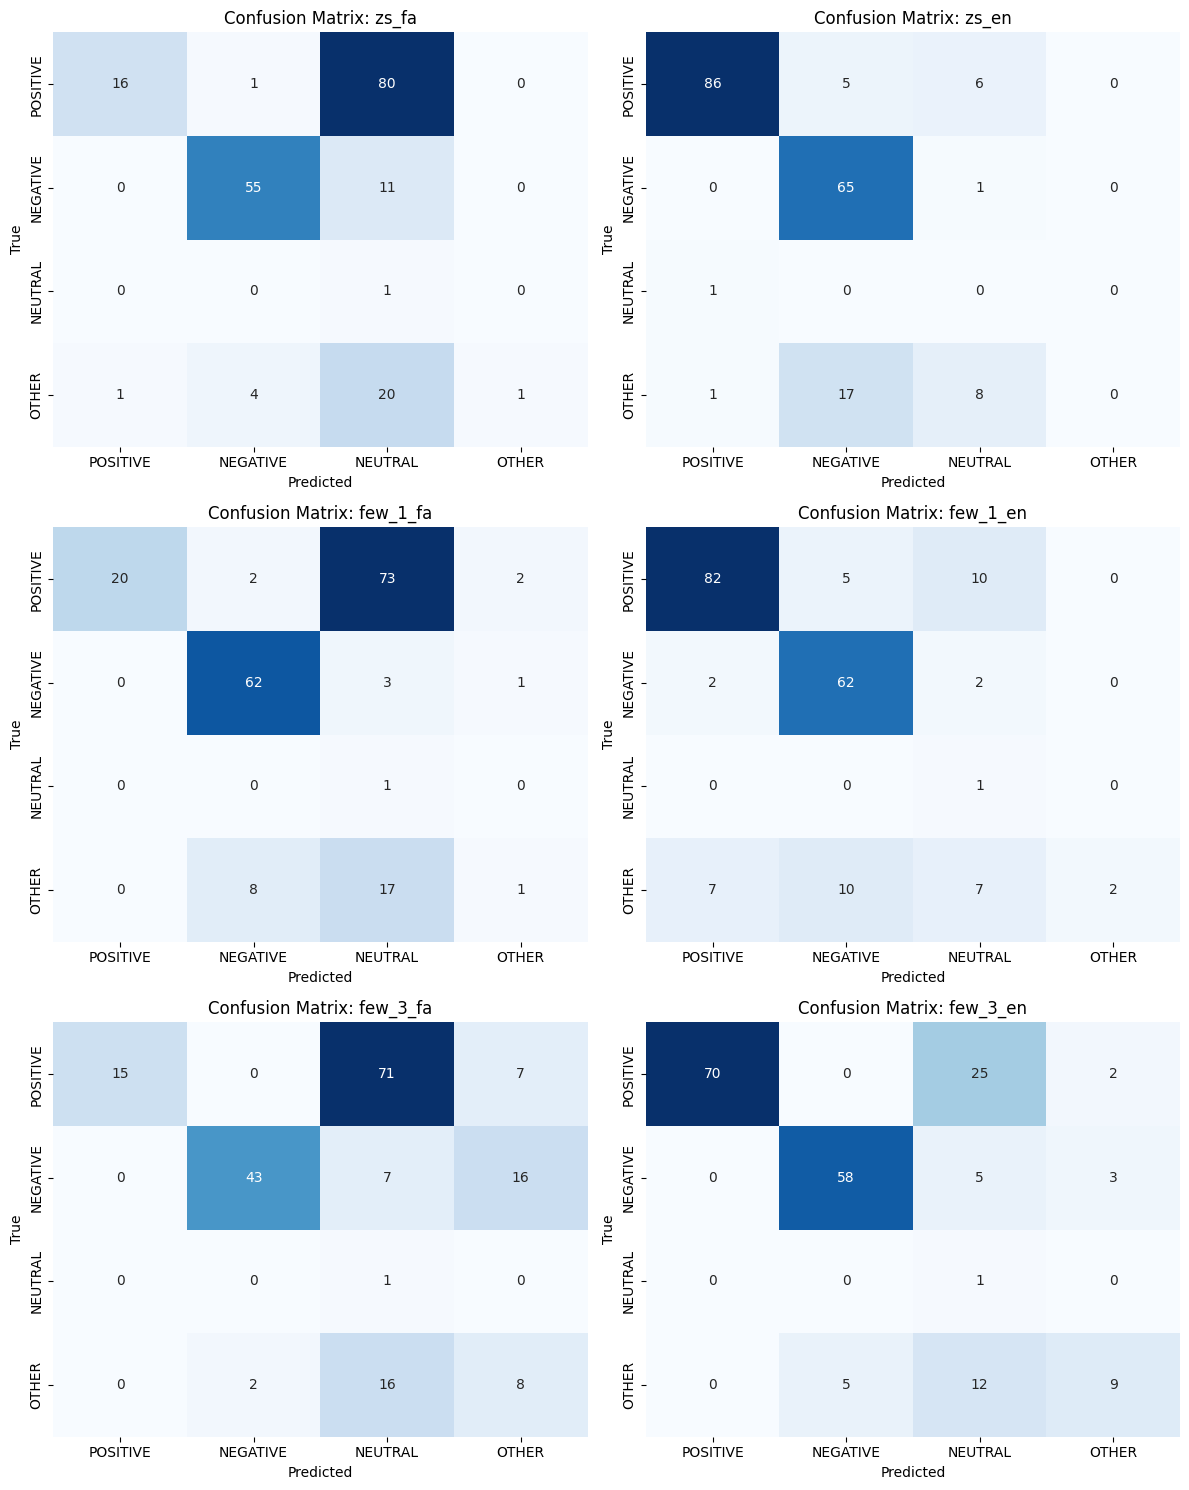

In [69]:
plot_confusion_matrix(model_1_result)

In [70]:
show_metrics_grid(model_1_result)

,precision,recall,f1-score,support
POSITIVE,0.941,0.165,0.281,97.0
NEGATIVE,0.917,0.833,0.873,66.0
NEUTRAL,0.009,1.000,0.018,1.0
OTHER,1.000,0.038,0.074,26.0
accuracy,0.384,0.384,0.384,190.0
macro avg,0.717,0.509,0.311,190.0
weighted avg,0.936,0.384,0.457,190.0
,precision,recall,f1-score,support
POSITIVE,1.000,0.206,0.342,97.0
NEGATIVE,0.861,0.939,0.899,66.0


### universitytehran/PersianMind-v1.0

In [71]:
map_sentiment(model_2_result)

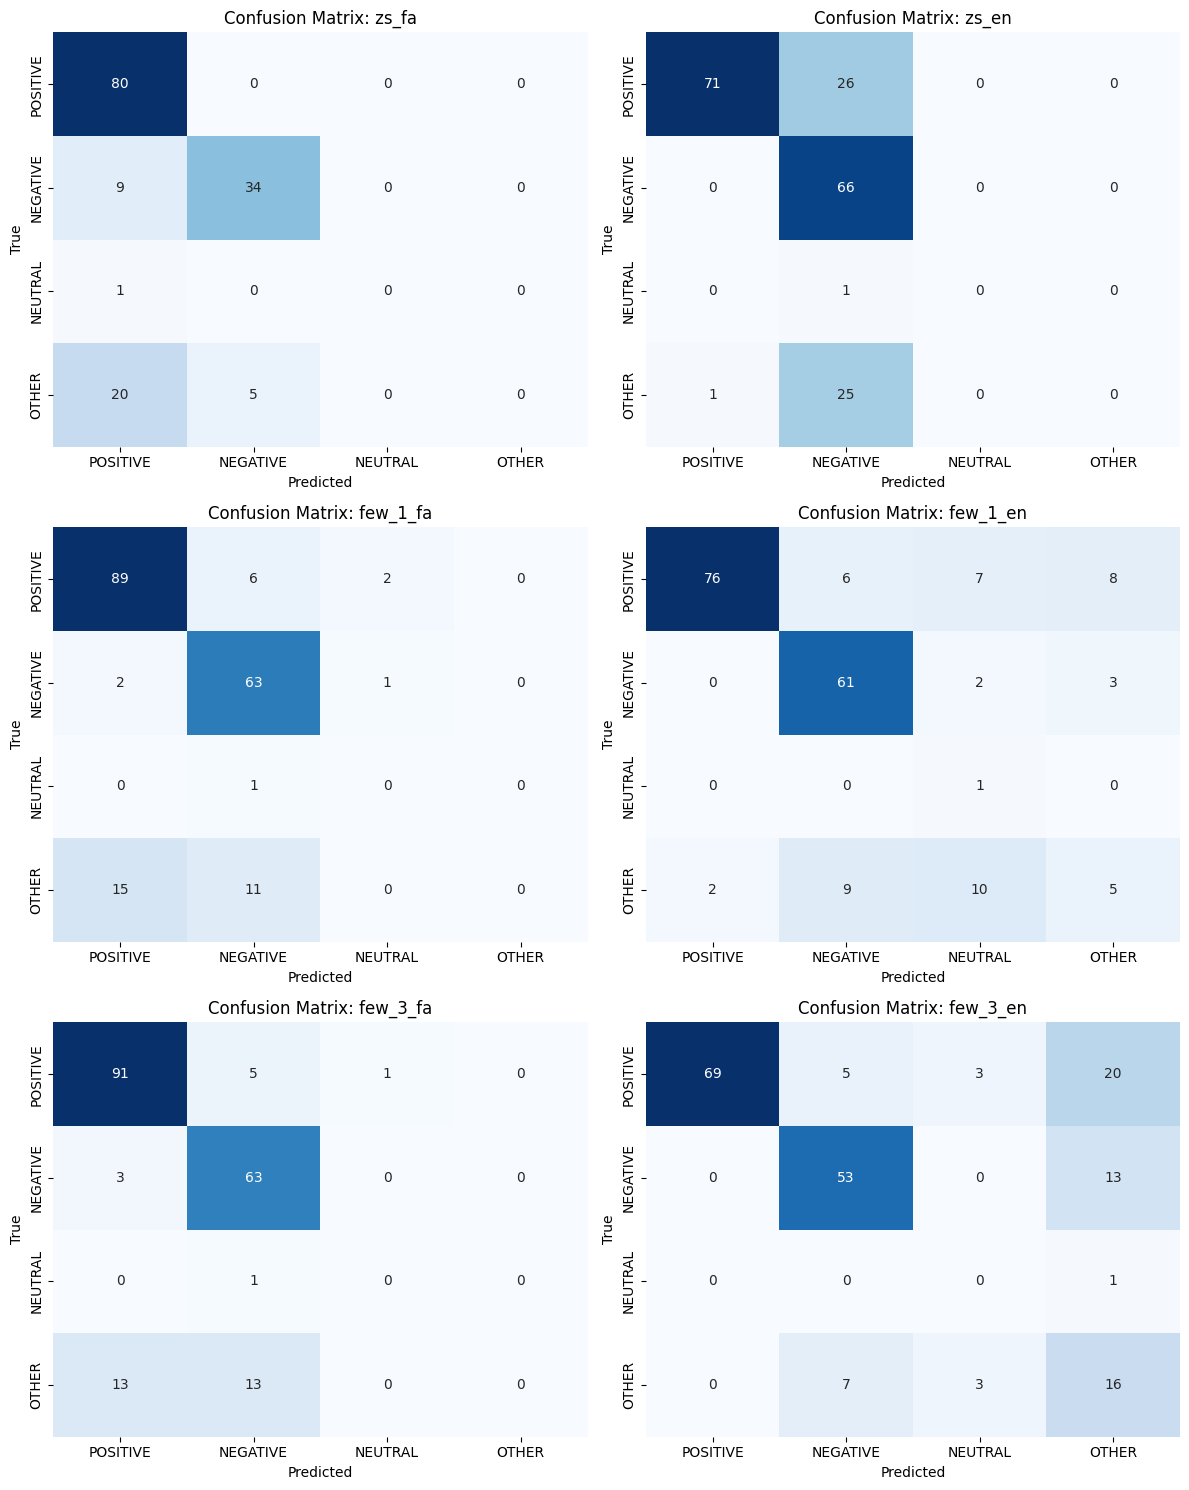

In [72]:
plot_confusion_matrix(model_2_result)

In [73]:
show_metrics_grid(model_2_result)

,precision,recall,f1-score,support
POSITIVE,0.727,0.825,0.773,97.0
NEGATIVE,0.872,0.515,0.648,66.0
NEUTRAL,0.000,0.000,0.000,1.0
OTHER,0.000,0.000,0.000,26.0
micro avg,0.765,0.600,0.673,190.0
macro avg,0.400,0.335,0.355,190.0
weighted avg,0.674,0.600,0.620,190.0
accuracy,0.600,0.600,0.600,190.0
,precision,recall,f1-score,support
POSITIVE,0.840,0.918,0.877,97.0


### CohereLabs/aya-expanse-8b

In [74]:
map_sentiment(model_3_result)

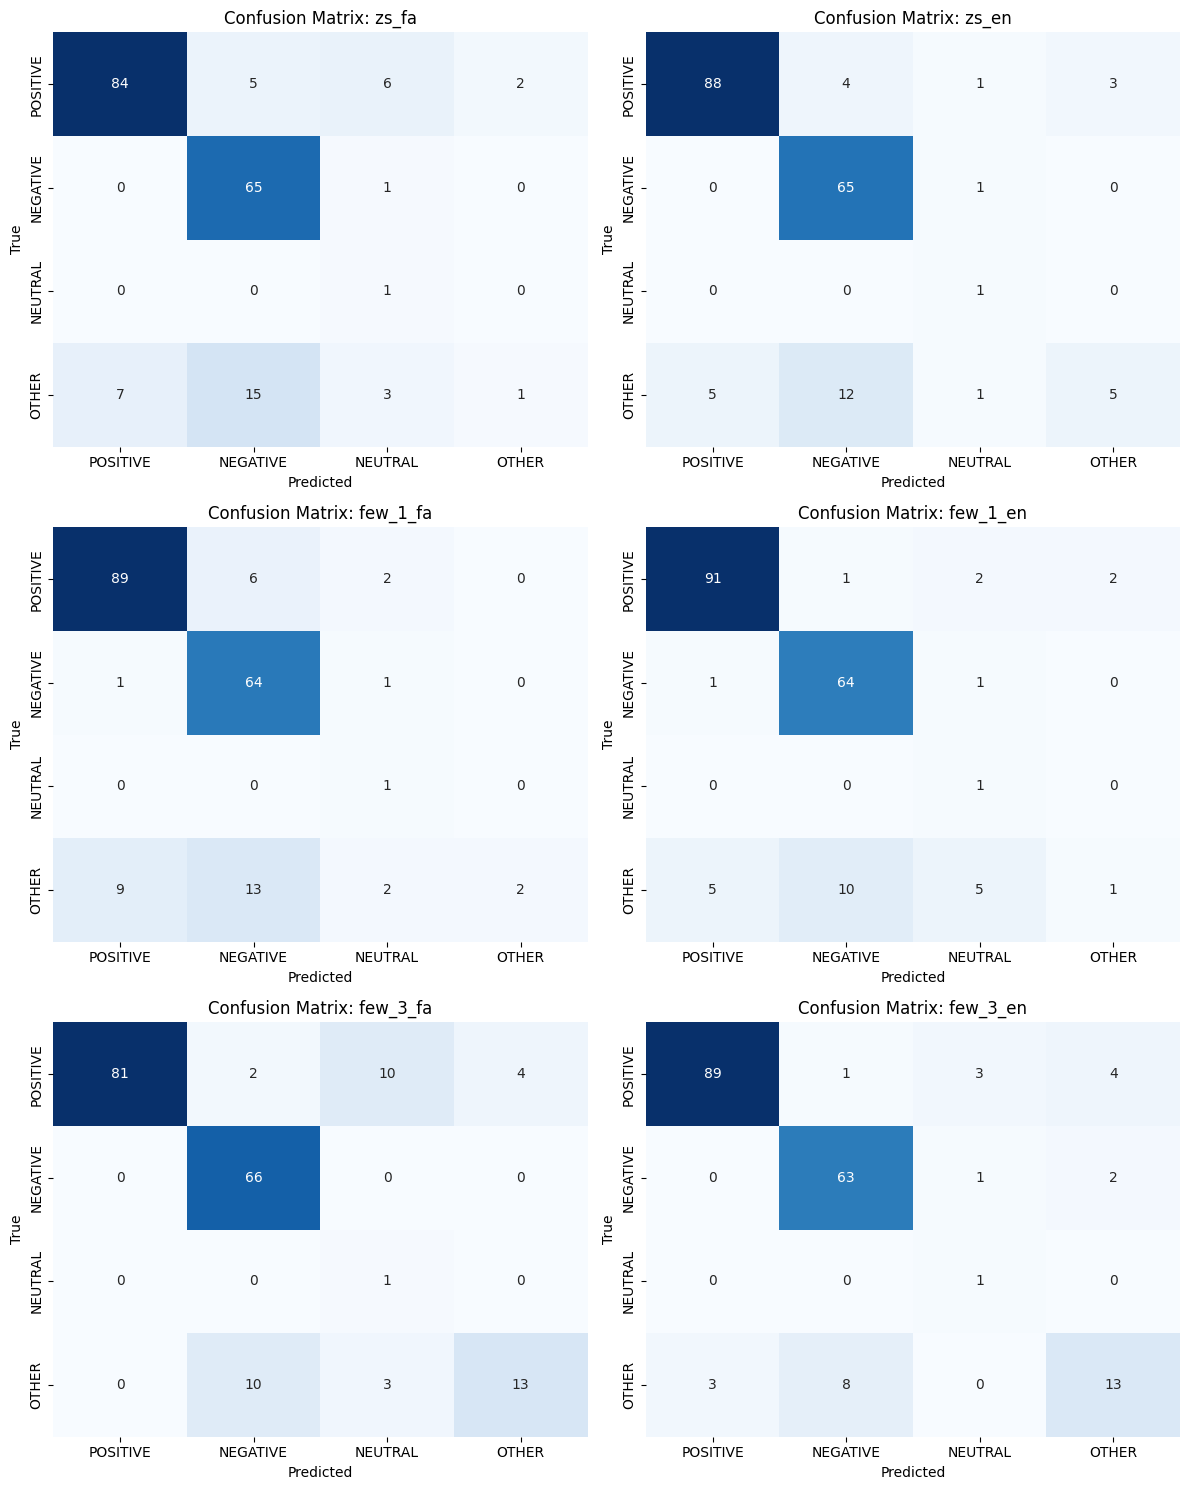

In [75]:
plot_confusion_matrix(model_3_result)

In [76]:
show_metrics_grid(model_3_result)

,precision,recall,f1-score,support
POSITIVE,0.923,0.866,0.894,97.0
NEGATIVE,0.765,0.985,0.861,66.0
NEUTRAL,0.091,1.000,0.167,1.0
OTHER,0.333,0.038,0.069,26.0
accuracy,0.795,0.795,0.795,190.0
macro avg,0.528,0.722,0.498,190.0
weighted avg,0.783,0.795,0.766,190.0
,precision,recall,f1-score,support
POSITIVE,0.899,0.918,0.908,97.0
NEGATIVE,0.771,0.970,0.859,66.0


### MaralGPT/Maral-7B-alpha-1

In [77]:
map_sentiment(model_4_result)

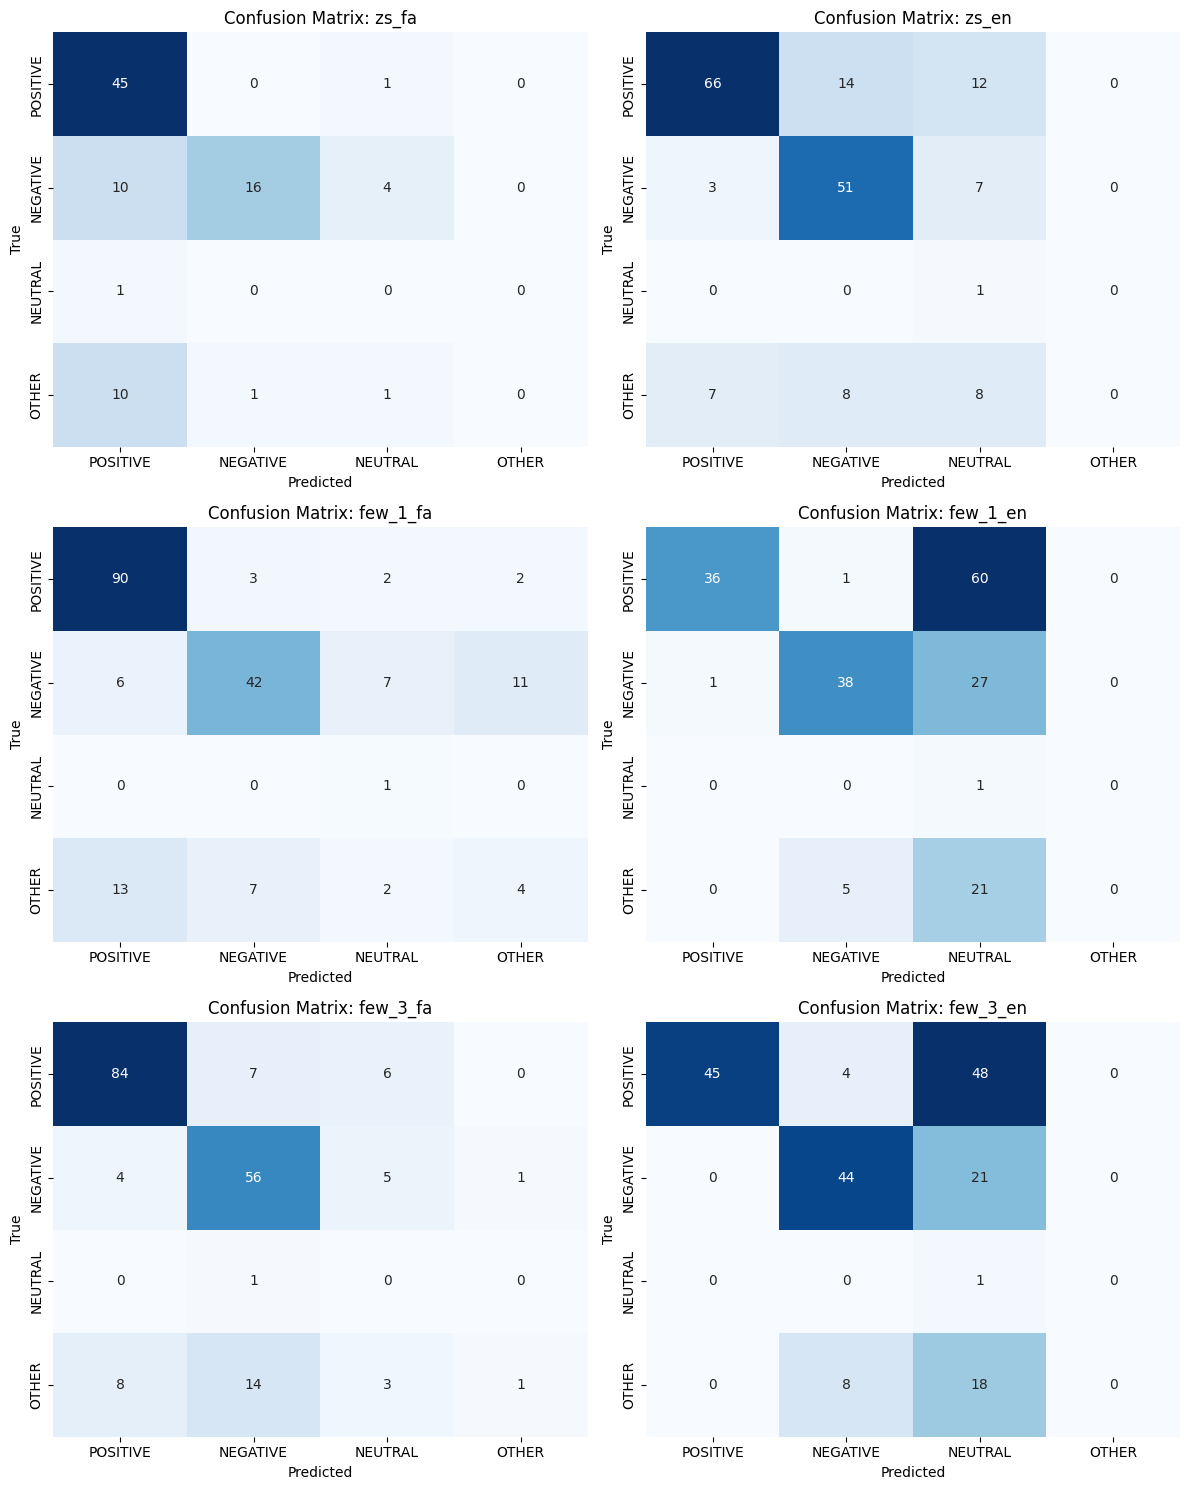

In [78]:
plot_confusion_matrix(model_4_result)

In [79]:
show_metrics_grid(model_4_result)

,precision,recall,f1-score,support
POSITIVE,0.682,0.464,0.552,97.0
NEGATIVE,0.941,0.242,0.386,66.0
NEUTRAL,0.000,0.000,0.000,1.0
OTHER,0.000,0.000,0.000,26.0
micro avg,0.685,0.321,0.437,190.0
macro avg,0.406,0.177,0.234,190.0
weighted avg,0.675,0.321,0.416,190.0
accuracy,0.321,0.321,0.321,190.0
,precision,recall,f1-score,support
POSITIVE,0.826,0.928,0.874,97.0


### MehdiHosseiniMoghadam/AVA-Llama-3-V2

In [80]:
map_sentiment(model_5_result)

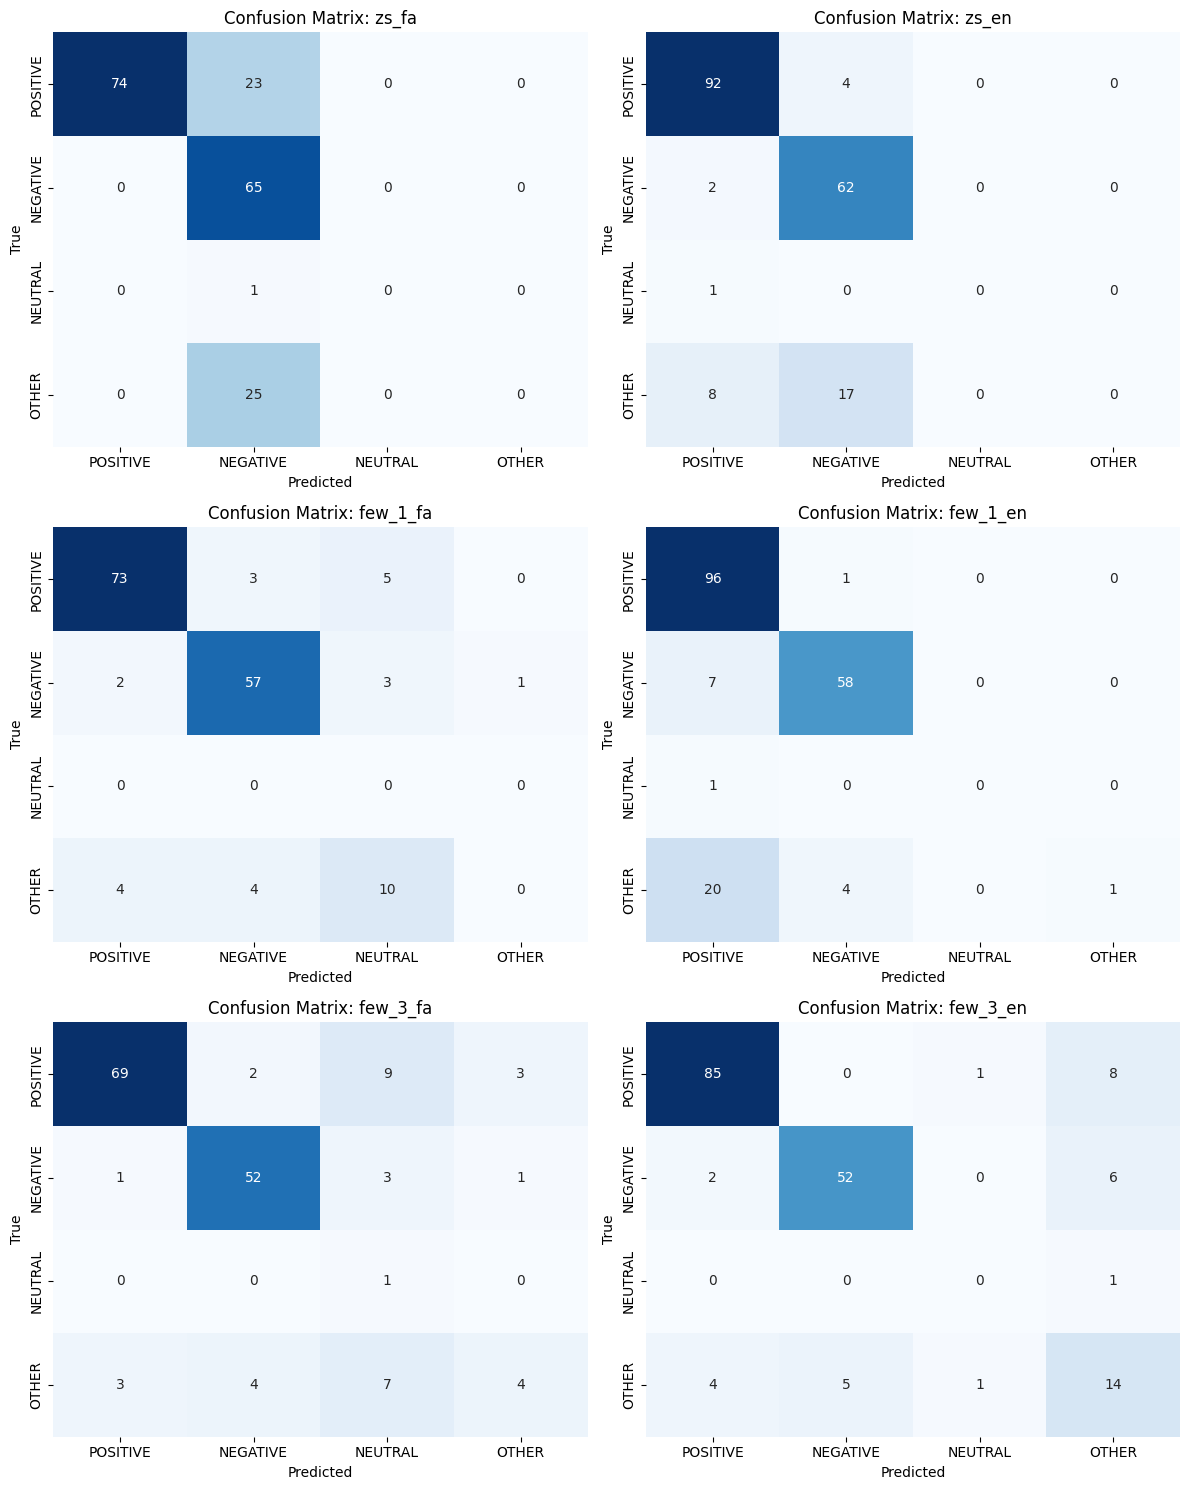

In [81]:
plot_confusion_matrix(model_5_result)

In [82]:
show_metrics_grid(model_5_result)

,precision,recall,f1-score,support
POSITIVE,1.000,0.763,0.865,97.0
NEGATIVE,0.570,0.985,0.722,66.0
NEUTRAL,0.000,0.000,0.000,1.0
OTHER,0.000,0.000,0.000,26.0
micro avg,0.739,0.732,0.735,190.0
macro avg,0.393,0.437,0.397,190.0
weighted avg,0.709,0.732,0.693,190.0
accuracy,0.732,0.732,0.732,190.0
,precision,recall,f1-score,support
POSITIVE,0.924,0.753,0.830,97.0


### ViraIntelligentDataMining/PersianLLaMA-13B-Instruct

In [83]:
map_sentiment(model_6_result)

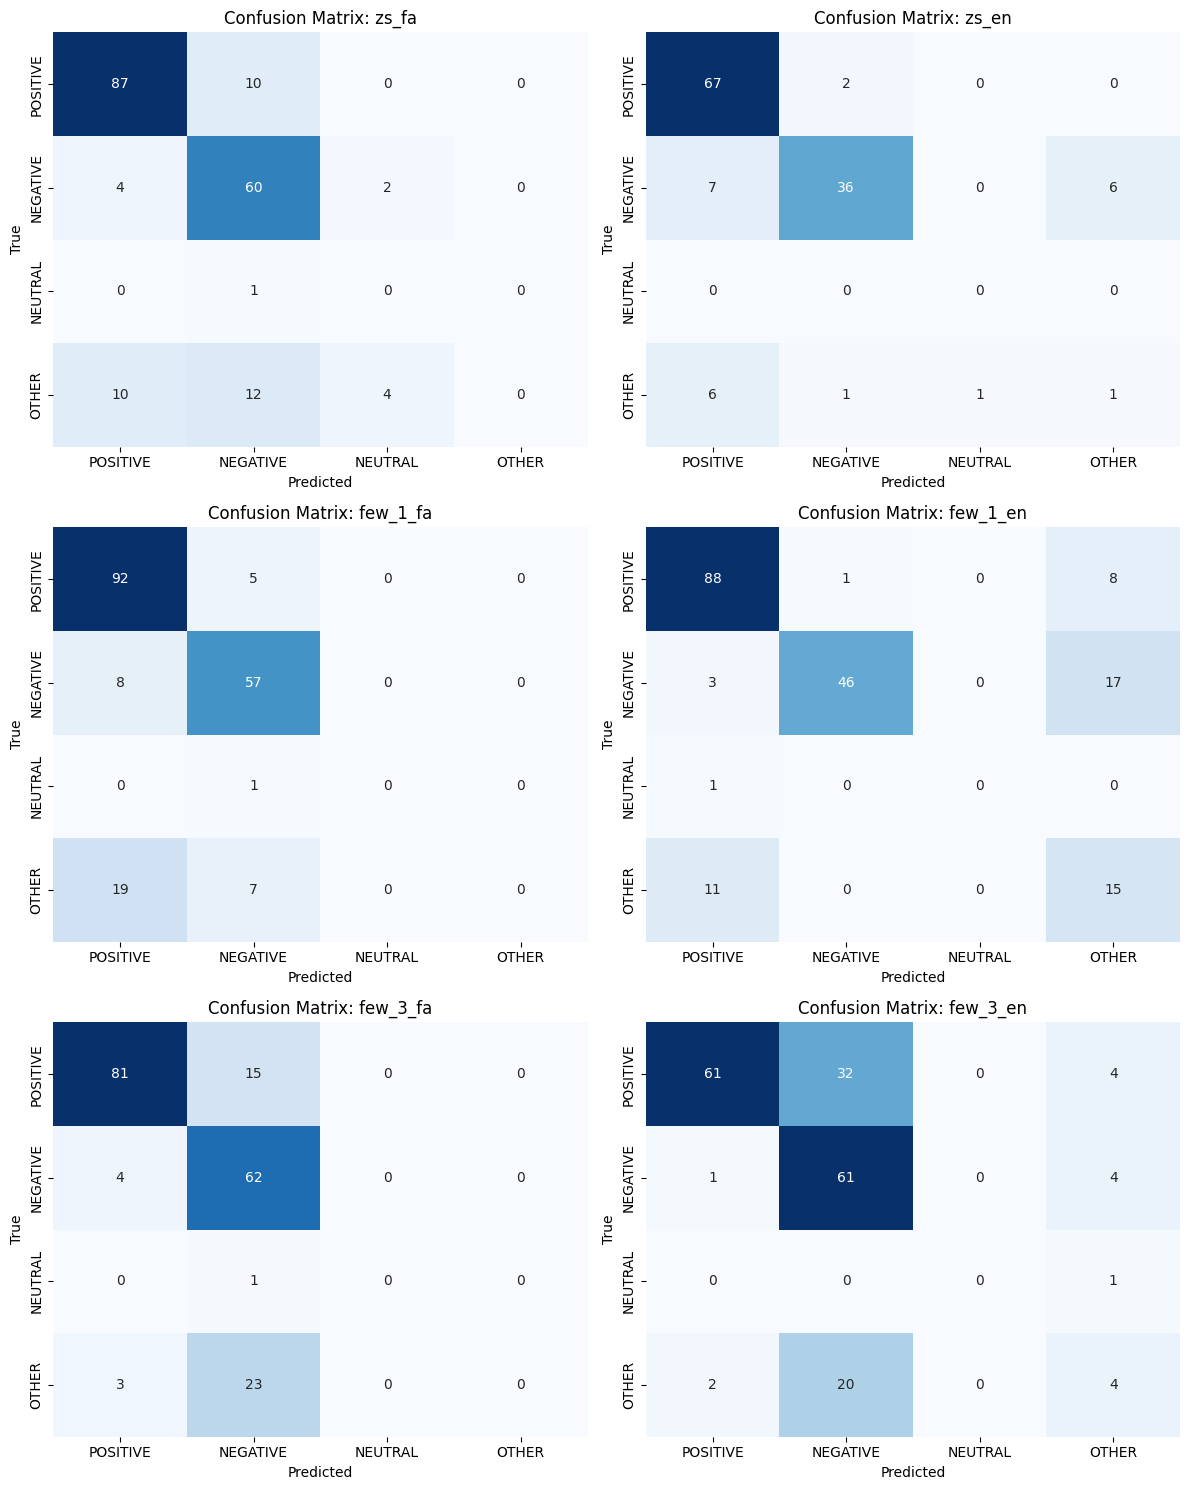

In [84]:
plot_confusion_matrix(model_6_result)

In [85]:
show_metrics_grid(model_6_result)

,precision,recall,f1-score,support
POSITIVE,0.861,0.897,0.879,97.0
NEGATIVE,0.723,0.909,0.805,66.0
NEUTRAL,0.000,0.000,0.000,1.0
OTHER,0.000,0.000,0.000,26.0
accuracy,0.774,0.774,0.774,190.0
macro avg,0.396,0.451,0.421,190.0
weighted avg,0.691,0.774,0.728,190.0
,precision,recall,f1-score,support
POSITIVE,0.773,0.948,0.852,97.0
NEGATIVE,0.814,0.864,0.838,66.0


## Conclusion

In [86]:
def get_best_experiment(metrics):
    result = {}
    for k, v in metrics.items():
        best_accuracy = 0
        best = None
        key = ""
        for _, experiment in v.items():
            if experiment.loc['weighted avg']['f1-score'] > best_accuracy:
                best = experiment
                best_accuracy = experiment.loc['weighted avg']['f1-score']
                key = _
        result[k+'-'+key] = {}
        result[k+'-'+key]['best'] = best
    return result

In [87]:
metrics = {
    "PartAI/Dorna2-Llama3.1-8B-Instruct": calculate_metrics(model_1_result),
    "universitytehran/PersianMind-v1.0": calculate_metrics(model_2_result),
    "CohereLabs/aya-expanse-8b": calculate_metrics(model_3_result),
    "MaralGPT/Maral-7B-alpha-1": calculate_metrics(model_4_result),
    "MehdiHosseiniMoghadam/AVA-Llama-3-V2": calculate_metrics(model_5_result),
    "ViraIntelligentDataMining/PersianLLaMA-13B-Instruct": calculate_metrics(model_6_result)
}

In [88]:
best_for_each_model = get_best_experiment(metrics)

### Radar Chart

In [89]:
def plot_radar_chart(data, title, key, ax):
    metrics = ['POSITIVE',
               'NEGATIVE',
               'NEUTRAL',
               'OTHER',
               'macro avg',
               'weighted avg',
               'accuracy']

    N = len(metrics)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    theta = np.concatenate([theta, [theta[0]]])

    ax.plot(subplot_kw={'projection': 'polar'})

    ax.set_title(title, y=1.15, fontsize=20)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(90)
    ax.spines['polar'].set_zorder(1)
    ax.spines['polar'].set_color('lightgrey')

    color_palette = [
        '#FF0000',
        '#0000FF',
        '#FFD700',
        '#FF8C00',
        '#008000',
        '#9467bd']

    idx = 0

    for model_name, metric in data.items():
        experiment = metric[key]
        values = experiment.loc[metrics]['f1-score'].to_list()
        values = values + [values[0]]
        ax.plot(theta, values, linewidth=1.75, linestyle='solid', label=model_name, marker='o', markersize=10, color=color_palette[idx % len(color_palette)])
        #ax.fill(theta, values, alpha=0.50, color=color_palette[idx % len(color_palette)])
        idx+=1

    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels(["0", "20", "40", "60", "80", "100"], color="black", size=12)

    ax.set_xticks(theta)
    ax.set_xticklabels(metrics+[metrics[0]], color='black', size=12)
    return fig

### All Experiments

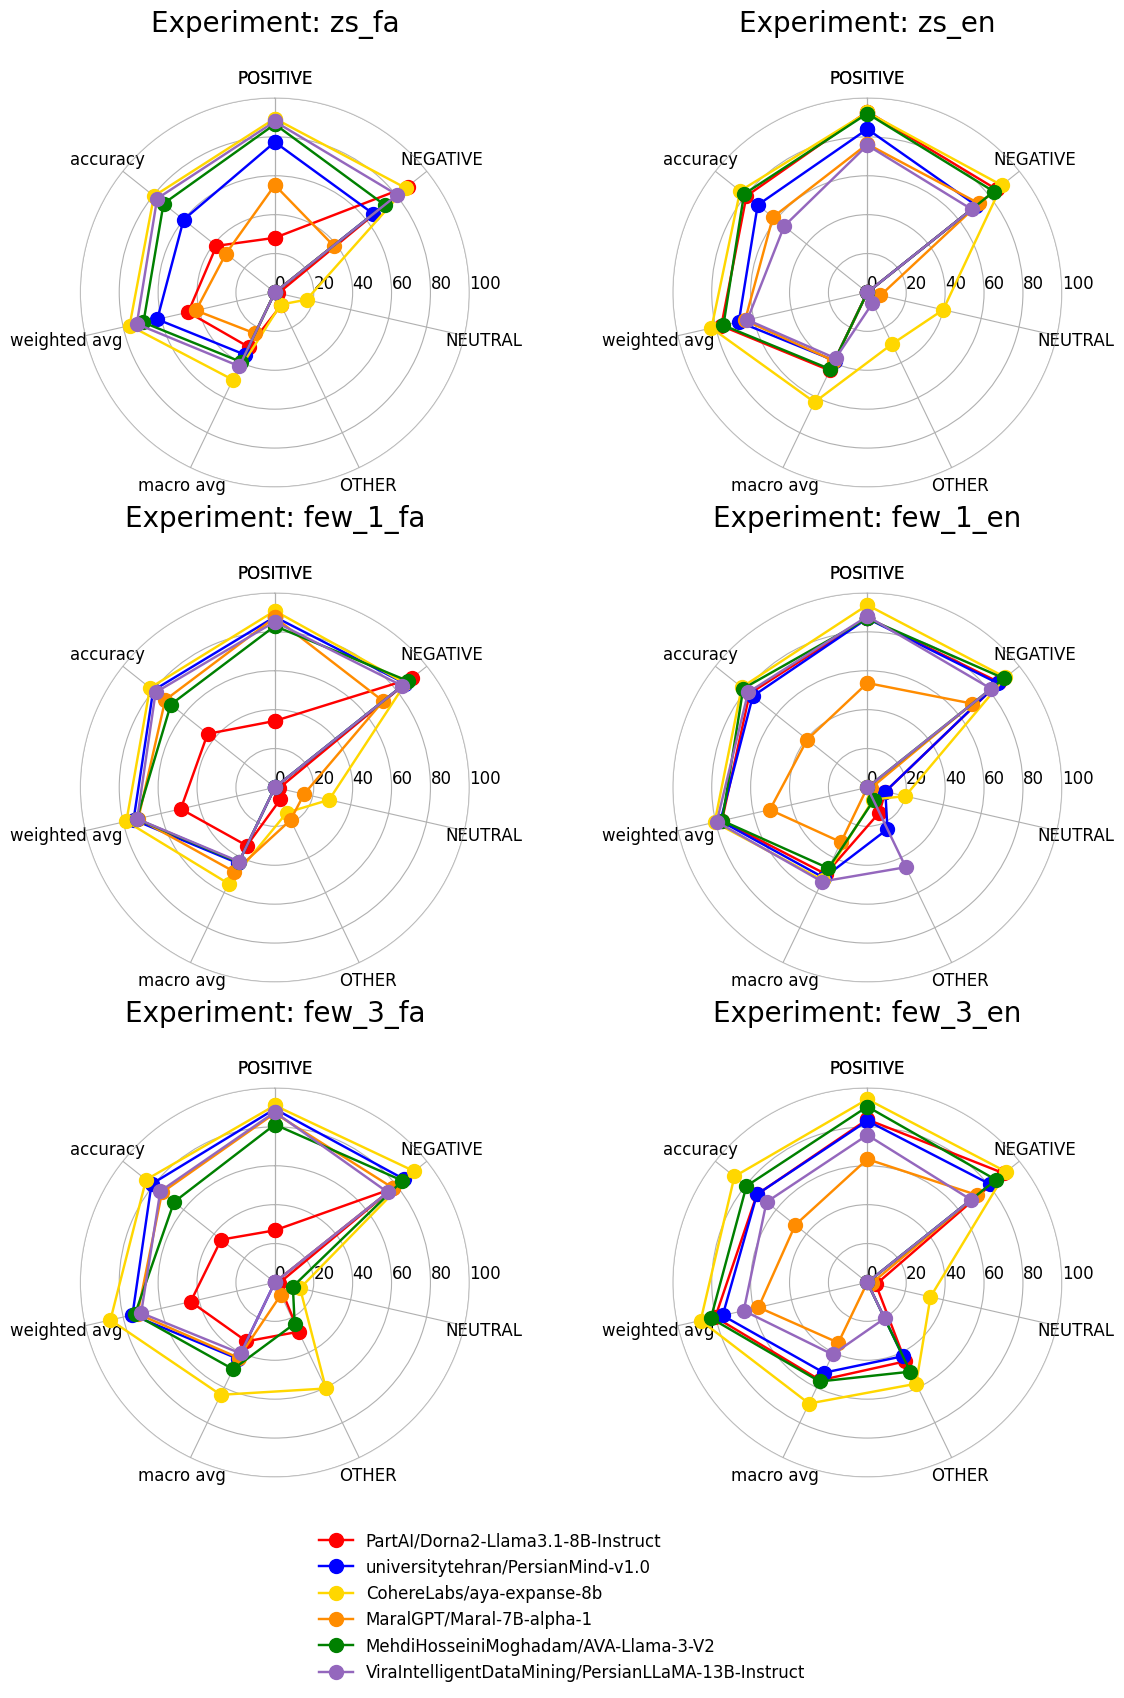

In [90]:
keys = list(prompts.keys())

num_charts = len(keys)
cols = 2
rows = math.ceil(num_charts / cols)

fig, axs = plt.subplots(rows, cols, subplot_kw=dict(polar=True), figsize=(12, 5 * rows))

axs = axs.reshape(rows, cols) if rows > 1 else [axs]

for idx, key in enumerate(keys):
    row, col = divmod(idx, cols)
    ax = axs[row][col]
    plot_radar_chart(metrics, f"Experiment: {key}", key, ax)

for idx in range(len(keys), rows * cols):
    row, col = divmod(idx, cols)
    fig.delaxes(axs[row][col])

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.01),
    fontsize=12,
    frameon=False
)

plt.tight_layout()
plt.show()

### Best Model

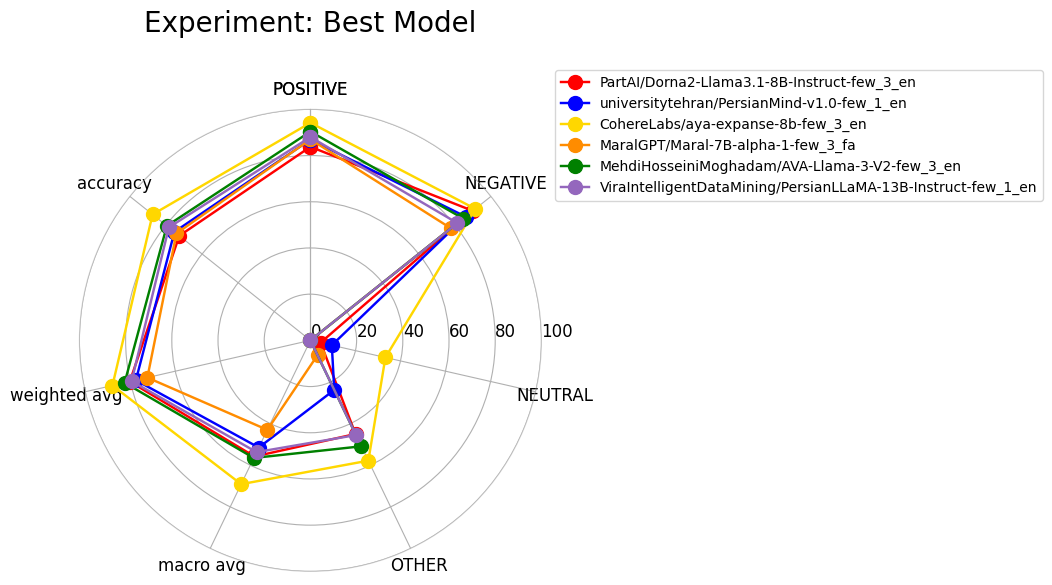

In [91]:
fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(6, 6))
plot_radar_chart(best_for_each_model, "Experiment: Best Model", 'best' ,ax)
ax.legend(loc='upper right', bbox_to_anchor=(2.1, 1.1))
plt.show()